In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline
import dask.dataframe as dd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader
import mitequinox.plot as pl


from fsspec.implementations.local import LocalFileSystem
#if not local : 
from xhistogram.xarray import histogram
#import mitequinox.sigp as sp

In [2]:
from dask.distributed import Client, LocalCluster
#
cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
#cluster = PBSCluster() #processes=7, cores=7
#w = cluster.scale(jobs=4)
#
client = Client(cluster)

/opt/anaconda3/envs/croco/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


### Following section is done on datarmor only

In [4]:
#Eulerian data
dsU =  xr.open_zarr(ut.work_data_dir+'rechunked/SSU_rot.zarr',consolidated=False)
dsV =  xr.open_zarr(ut.work_data_dir+'rechunked/SSV_rot.zarr',consolidated=False)

AttributeError: module 'mitequinox.utils' has no attribute 'work_data_dir'

In [5]:
def binned_mean(df,dl):
    """Average dataframe over bins width dl
    
    Parameters 
    df : dataframe with at least longitude, latitude and field to bin in columns
    dl : bin width
    
    Returns
    df_mean : dataset with averaged fields
    """
    lon = np.arange(-180.,180., dl)
    lat = np.arange(-70., 70., dl)
    df['lon_cut'] = pd.cut(df['lon'], lon)
    df['lat_cut'] = pd.cut(df['lat'], lat)
    df_mean = df.groupby(['lon_cut','lat_cut']).mean()
    df_mean = pa.add_geodata(df_mean)
    df_mean = (df_mean
     #     .drop(columns=['Coordinates'])
          .set_index(['lon', 'lat'])
         .to_xarray()
        )
    return df_mean

In [5]:
# Mean fields

dsU_mean = dsU.mean('time').persist()
dsV_mean = dsV.mean('time').persist()

In [95]:
# Grid point selection

face,i,j = 11, 2358, 1823
dsi = dsU.isel(face=face,i=i,j=i).persist()

dsiV = dsV.isel(face=face,i=i,j=i).persist()

### Figures Eulerian data

In [97]:
time = dsU.time.values#.compute()
XC = dsU.XC.values#.compute()

(array(15461.), array(15492.))

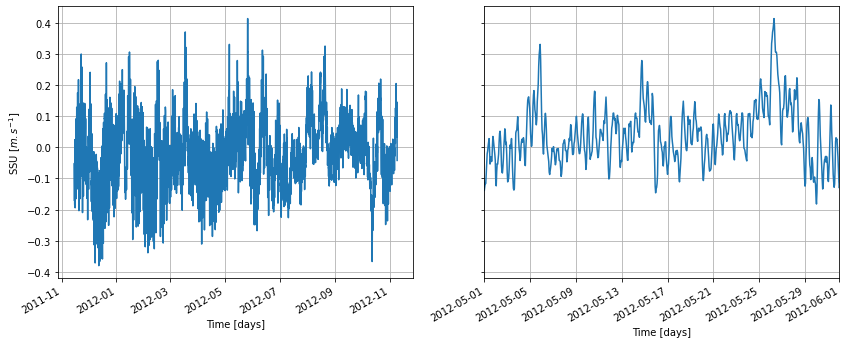

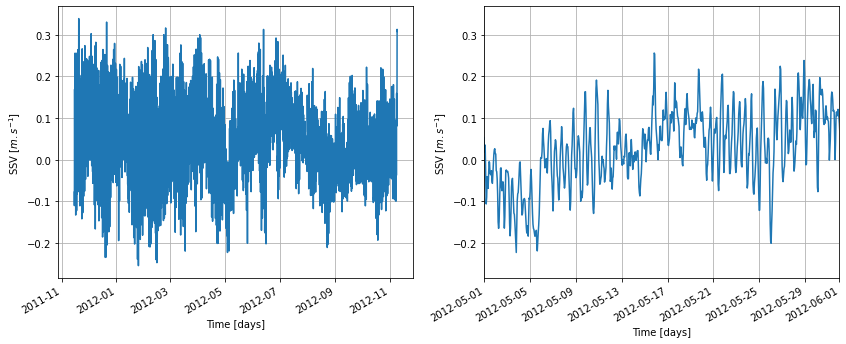

In [101]:
fig,axs = plt.subplots(1,2,figsize=(14,5),sharey=True)
for ax in axs:
    dsi.SSU_rot.plot(ax=ax)
    #dsiV.SSV_rot.plot(ax=ax)
    ax.grid();ax.set_title('');
    ax.set_xlabel('Time [days]');ax.set_ylabel('')
axs[0].set_ylabel(r'SSU [$m.s^{-1}$]')
axs[1].set_xlim('2012-05','2012-06')

fig,axs = plt.subplots(1,2,figsize=(14,5))
for ax in axs:
    dsiV.SSV_rot.plot(ax=ax)
    ax.grid();ax.set_ylabel(r'SSV [$m.s^{-1}$]'),ax.set_title('');
    ax.set_xlabel('Time [days]')
axs[1].set_xlim('2012-05','2012-06')

In [6]:
dsU_mean = dsU_mean.assign_coords({'XC':dsU_mean.XC,'YC':dsU_mean.YC})

In [74]:
dsU_mean['lon'] = 0*dsU_mean.face+dsU_mean.XC
dsU_mean['lat'] = 0*dsU_mean.face+dsU_mean.YC

In [88]:
lon,lat = dsU_mean.sel(face=11).lon.compute(),dsU_mean.sel(face=11).lat.compute()

In [91]:
jlon = lon.where((lon<=-89)&(lon>=-91)&(lat<=-29)&(lat>=-31),drop=True)

In [94]:
print(jlon.j.mean(),jlon.i.mean())

<xarray.DataArray 'j' ()>
array(1823.5)
Coordinates:
    face     int64 11 <xarray.DataArray 'i' ()>
array(2358.5)
Coordinates:
    face     int64 11


In [89]:
_lat = lat.sel(j=jlon,method='nearest')

In [7]:
dsU_mean.to_zarr('/home1/datawork/zcaspar/mit4320/'+'ESSU_mean.zarr')

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/e

{'fig': <Figure size 1080x1080 with 1 Axes>,
 'ax': <GeoAxesSubplot:title={'center':'face = 12'}, xlabel='XC', ylabel='YC'>,
 'cbar': None}

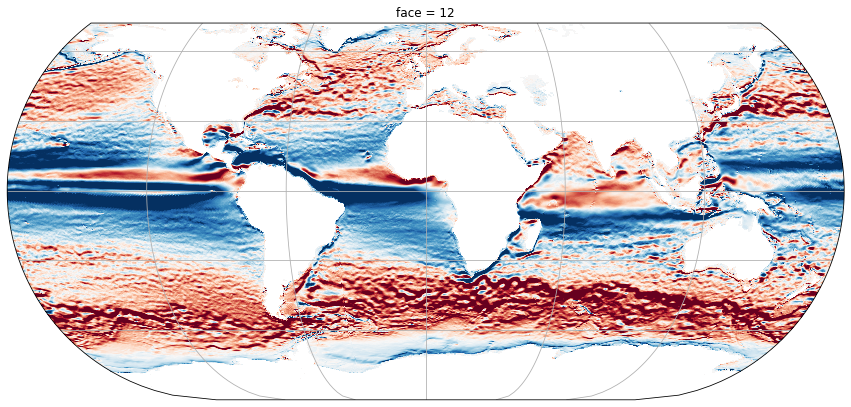

In [53]:
# Map of mean SSU
pl.plot_pretty(dsU_mean.SSU_rot,cmap='RdBu_r',vmax=0.2,vmin=-0.2,land=False,colorbar=False)

In [55]:
dsV_mean = dsV_mean.assign_coords({'XC':dsV_mean.XC,'YC':dsV_mean.YC})

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/e

{'fig': <Figure size 1080x1080 with 1 Axes>,
 'ax': <GeoAxesSubplot:title={'center':'face = 12'}, xlabel='XC', ylabel='YC'>,
 'cbar': None}

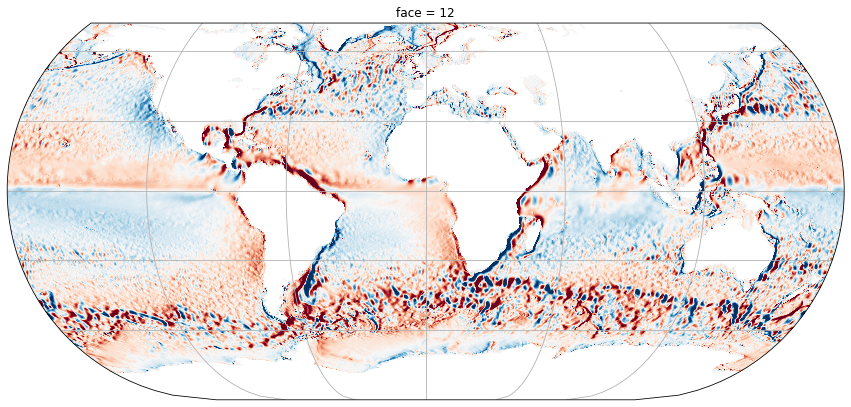

In [56]:
# Map of mean SSV
pl.plot_pretty(dsV_mean.SSV_rot,cmap='RdBu_r',vmax=0.2,vmin=-0.2,land=False,colorbar=False)

In [ ]:
dsU_residual = dsU.SSU_rot-dsU_mean.SSU_rot
dsV_residual = dsV.SSV_rot-dsV_mean.SSV_rot

In [ ]:
ds = xr.merge([dsU,dsV,dsU_residual,dsV_residual])

In [ ]:
MKE = (ds.SSU_rot**2+ds.SSV_rot**2).mean('time').persist()

In [ ]:
EKE = (dsU_residual.SSU_rot**2+ds.SSV_rot**2).mean('time').persist()

In [ ]:
dsV_mean = dsV_mean.assign_coords({'XC':dsV_mean.XC,'YC':dsV_mean.YC})

In [ ]:
# Map of mean SSV
pl.plot_pretty(MKE,cmap='OrRd',vmax=0.1,vmin=0,land=False,colorbar=False)

### Lagrangian data

In [8]:
# Lagrangian data
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_T365j_dt1j_dij50'
p = pa.parcels_output(root_dir+run_name, parquets=['time'])
df = p.df['time']
df = pa.degs2ms(df) #Convert in m/s 


### Figures and selection Lagrangian data

In [9]:
t0 = df.index.min().compute()
t0

Timestamp('2011-11-15 00:00:00')

In [35]:
df0 = df[[df.index.values==t0]].persist()

ValueError: Cannot call len() on object with unknown chunk size.

A possible solution: https://docs.dask.org/en/latest/array-chunks.html#unknown-chunks
Summary: to compute chunks sizes, use

   x.compute_chunk_sizes()  # for Dask Array `x`
   ddf.to_dask_array(lengths=True)  # for Dask DataFrame `ddf`

In [35]:
traj = df.trajectory.compute()


In [39]:
trajec = np.unique(traj.values)

In [55]:
mean_df = df.groupby('trajectory').mean().persist()

In [57]:
_mean_df = mean_df[['lon','lat']]

In [58]:
_mean_df = _mean_df.compute()

In [65]:
_mean_df[(_mean_df.lon>-95)&(_mean_df.lon<-85)&
        (_mean_df.lat>-35)&(_mean_df.lat<-25)]

,lon,lat
trajectory,,
44000473,-92.811483,-27.557489
44000523,-88.186770,-25.076985
44000549,-89.597445,-25.835262
44000573,-87.448792,-25.206831
44000574,-89.833718,-25.989357
...,...,...
44001791,-90.922148,-33.944895
44001931,-88.390140,-31.313238
44001955,-92.143482,-30.859871


In [66]:
itraj = 44001791

In [67]:
dfi = df[df.trajectory==itraj].persist()

In [68]:
dfi = dfi.compute()

In [69]:
dfi = dfi.reset_index().sort_values('time').set_index('time')

In [70]:
time = dfi.index.values

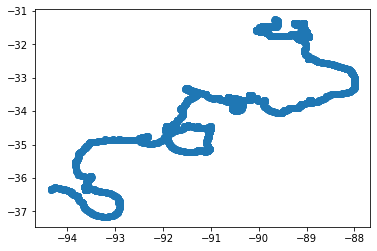

In [71]:
plt.scatter(dfi.lon,dfi.lat)

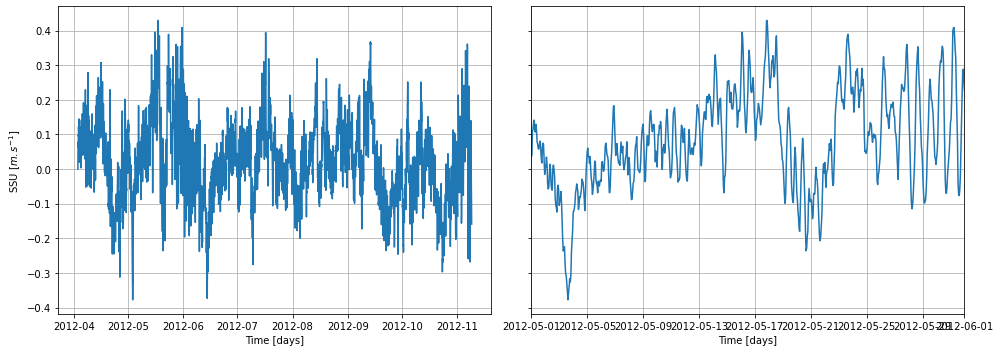

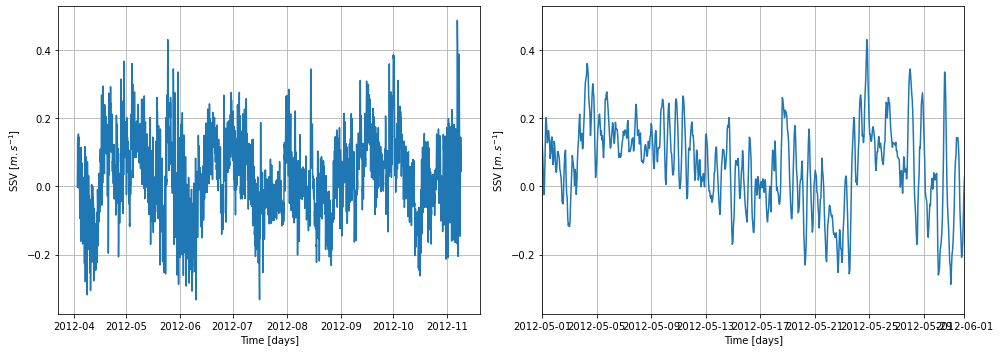

In [72]:
fig,axs = plt.subplots(1,2,figsize=(14,5),sharey=True)
for ax in axs:
    ax.plot(time,dfi.zonal_velocity.values)
    ax.grid();ax.set_title('');
    ax.set_xlabel('Time [days]')
axs[0].set_ylabel(r'SSU [$m.s^{-1}$]')
axs[1].set_xlim('2012-05','2012-06')
fig.tight_layout()

fig,axs = plt.subplots(1,2,figsize=(14,5))
for ax in axs:
    ax.plot(time,dfi.meridional_velocity.values)
    ax.grid();ax.set_ylabel(r'SSV [$m.s^{-1}$]'),ax.set_title('');
    ax.set_xlabel('Time [days]')
axs[1].set_xlim('2012-05','2012-06')
fig.tight_layout()

### End of datarmor cells

## Local

In [3]:
def plot_maps(ds,colmap='RdBu_r',vlim=(-0.01,0.01),axes=111,**kwargs):
    crs = ccrs.Robinson()
    #fig = plt.figure(figsize=figsize)
    cbar_kwargs = {'fraction':0.02}
    cbar_kwargs.update(**kwargs)
    ax = fig.add_subplot(axes,projection=crs)
    ds.plot(vmax=vlim[1],vmin=vlim[0],y='lat_bin',ax=ax,
            transform=ccrs.PlateCarree(),cmap=colmap,label=False,#**kwargs,
            cbar_kwargs=cbar_kwargs) #{'fraction':0.02,'label':'energy'}
    ax.gridlines(draw_labels=True)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND)
    return fig,ax

In [4]:
root_dir = '/Users/zcaspar/codes/mit4320/'
fig_dir = '/Users/zcaspar/Documents/Figures_manuscript/'

In [5]:
# Load data
ds_mean = xr.open_zarr(root_dir+'ESSU_mean.zarr').persist()

In [6]:
ds_mean

<xarray.Dataset>
Dimensions:  (face: 13, j: 4320, i: 4320)
Coordinates:
    XC       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
Data variables:
    CS       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    SN       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    SSU_rot  (face, j, i) float32 dask.array<chunksize=(1, 192, 576), meta=np.ndarray>
    rA       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>

In [6]:
ds_mean['lon'] = 0*ds_mean.face+ds_mean['XC']
ds_mean['lat'] = 0*ds_mean.face+ds_mean['YC']
ds_mean = ds_mean.persist()

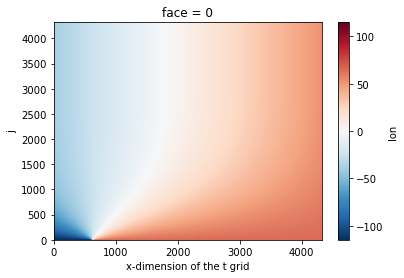

In [7]:
ds_mean.lon.sel(face=0).plot()

In [8]:
ds_mean = ds_mean.assign_coords({'lon':ds_mean.lon,'lat':ds_mean.lat})

### Figure 4.2.2

In [9]:
dl = 1.
lon_bins = np.arange(-180.,180., dl)
lat_bins = np.arange(-60, 60, dl)
V = 'SSU_rot'

In [11]:
ds_mean = ds_mean.where(ds_mean.Depth>500).persist()

In [10]:
#from xhistogram.xarray import histogram
N = histogram(ds_mean.lon.rename('lon'), ds_mean.lat.rename('lat'), 
              bins=[lon_bins,lat_bins], 
              dim=['i', 'j', 'face']
             ).persist()

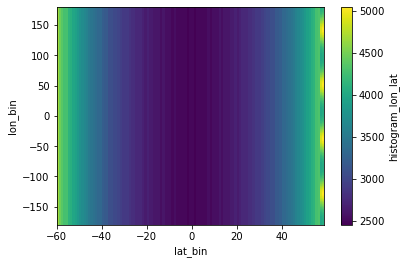

In [11]:
N.plot()

In [12]:
ds_binned = (histogram(ds_mean.lon.rename('lon'), ds_mean.lat.rename('lat'),bins=[lon_bins, lat_bins],
                       weights=ds_mean[V].fillna(0.),  #
                       dim=['i', 'j', 'face'])/(N)).rename('E_%s'%V).persist()

In [13]:
ds_binned = ds_binned.compute()

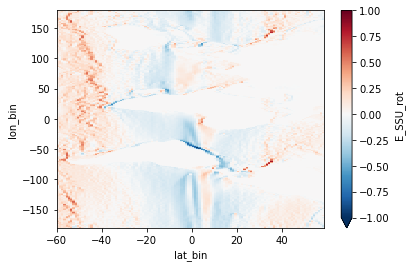

In [14]:
ds_binned.plot(vmax=1)

In [15]:
dsE = xr.open_dataset(root_dir+'EEi_SSU_mean.nc')
dsL = xr.open_dataset(root_dir+'LSSU_mean.nc')

In [16]:
def degs2ms(df, lat="lat"):
    """
    Convert velocity in degree per second in meter per second.
    See parcels code :
    https://github.com/OceanParcels/parcels/blob/6c83aa0acfe74f89bb8ce7a01de6357329d488d4/parcels/tools/converters.py
    Parameters:
    ----------
    df : dask dataframe in which the velcoity are in degree per second
    lat : name of the column corresponding to latitude, defaults is "lat"
    """
    df["zonal_velocity"] = (
        df["zonal_velocity"] * 1000.0 * 1.852 * 60.0 * np.cos(df[lat] * np.pi / 180)
    )
    df["meridional_velocity"] = df["meridional_velocity"] * 1000.0 * 1.852 * 60.0
    return df


In [17]:
dsL['zonal_velocity'] = dsL.zonal_velocity* 1000.0 * 1.852 * 60.0 * np.cos(dsL['lat_bin'] * np.pi / 180)

In [18]:
import matplotlib as mpl
mpl.rcParams["font.size"] = 13

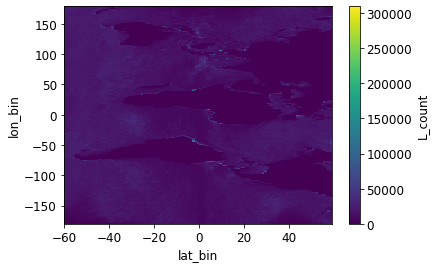

In [81]:
dsL.L_count.plot()

In [19]:
def plot_maps(ds,colmap='RdBu_r',vlim=(-0.01,0.01),axes=111,**kwargs):
    crs = ccrs.Robinson()
    #fig = plt.figure(figsize=figsize)
    cbar_kwargs = {'fraction':0.02}
    cbar_kwargs.update(**kwargs)
    ax = fig.add_subplot(axes,projection=crs)
    ds.plot(vmax=vlim[1],vmin=vlim[0],y='lat_bin',ax=ax,
            transform=ccrs.PlateCarree(),cmap=colmap,label=False,#**kwargs,
            cbar_kwargs=cbar_kwargs) #{'fraction':0.02,'label':'energy'}
    ax.gridlines(draw_labels=True)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND)
    return fig,ax

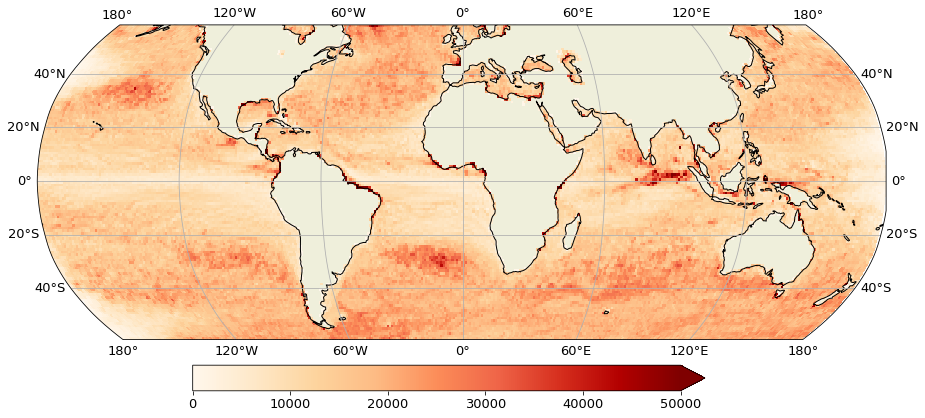

In [20]:
kwargs = {'orientation':'horizontal','fraction':0.07,'pad':0.07}#,'label':r'Ratio ($Log_{10}$)'}
kwargs.update({'label':r''})

figsize=(15,6)
cmap = 'OrRd'
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps((dsL.L_count.where(dsL.L_count>0))
                   ,colmap=cmap,vlim=(0,5e4),**kwargs)
#ax.set_title(r'Eulerian low frequency energy, $<[\bar u_E^2]_t>_b$',size=15)
fig.tight_layout()
fig.savefig(fig_dir+'Nb_drifters.png')

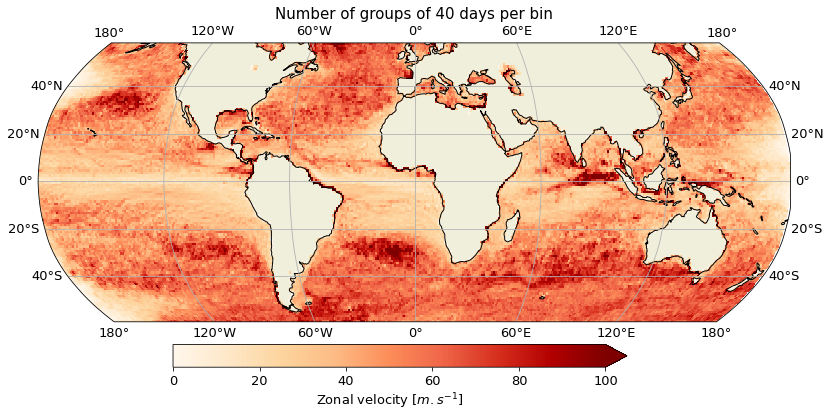

In [40]:
#.plot(y='lat_bin',cmap='OrRd',vmax=100)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(((dsL.L_count.where(dsL.L_count>0)*3/24)/40)
                   ,colmap='OrRd',vlim=(0,100),**kwargs)
ax.set_title(r'Number of groups of 40 days per bin',size=15)
fig.tight_layout()

In [ ]:
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps((dsL.L_count.where(dsL.L_count>0)/(40))
                   ,colmap=cmap,vlim=(0,5e4),**kwargs)
#ax.set_title(r'Eulerian low frequency energy, $<[\bar u_E^2]_t>_b$',size=15)
fig.tight_layout()

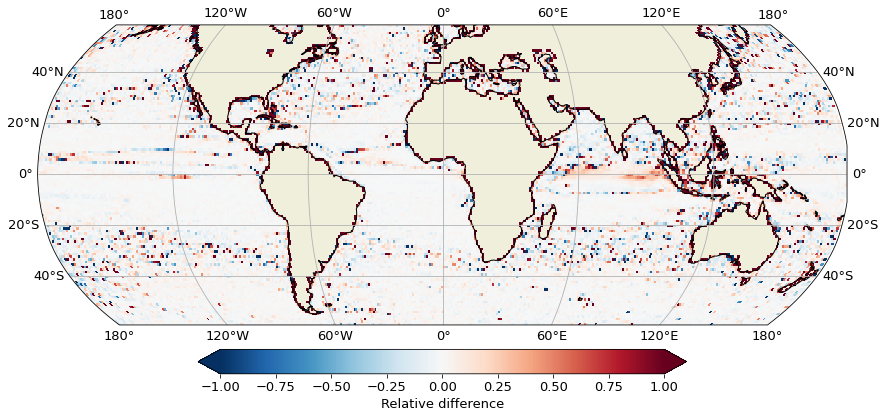

In [21]:
cmap = 'RdBu_r'
kwargs.update({'label':r'Relative difference'})
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps((dsE.mean_zonal_velocity-ds_binned)/ds_binned
                   ,colmap=cmap,vlim=(-1,1),**kwargs)
#ax.set_title(r'Eulerian low frequency energy, $<[\bar u_E^2]_t>_b$',size=15)
fig.tight_layout()
fig.savefig(fig_dir+'EiE_ssu.png')

/opt/anaconda3/envs/croco/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


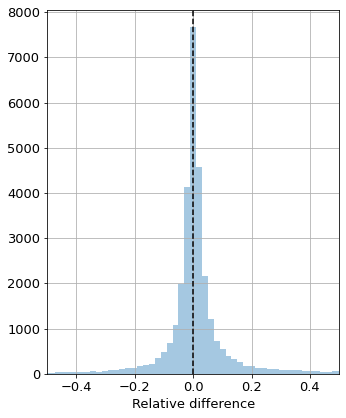

In [25]:
bins = np.linspace(-1,1,100)
import seaborn as sns

fig,ax= plt.subplots(figsize=(5,6))
axs = sns.distplot((dsE.mean_zonal_velocity-ds_binned)/ds_binned,bins=bins,kde=False)
axs.set_xlabel('Relative difference')
axs.grid();axs.axvline(0,c='k',linestyle='--')
axs.set_xlim(-0.5,0.5)
fig.tight_layout();
fig.savefig(fig_dir+'SSU_diff1.pdf',bbox_inches='tight')



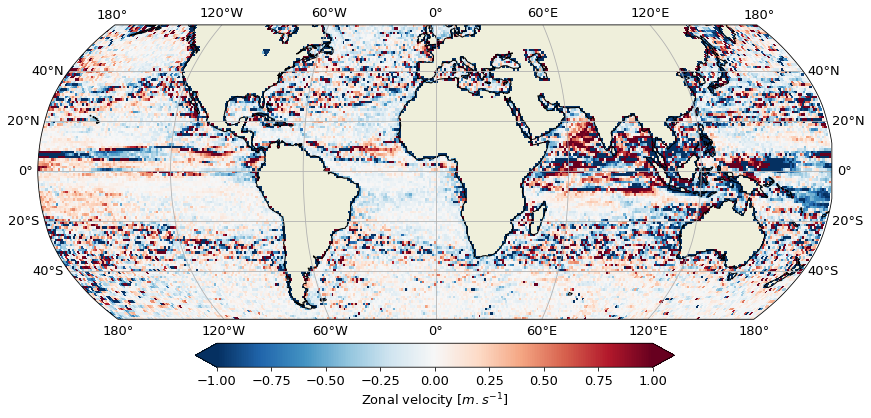

In [24]:
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps((dsL.zonal_velocity-dsE.mean_zonal_velocity)/ds_binned
                   ,colmap=cmap,vlim=(-1,1),**kwargs)
#ax.set_title(r'Eulerian low frequency energy, $<[\bar u_E^2]_t>_b$',size=15)
fig.tight_layout()
fig.savefig(fig_dir+'LE_ssu.png')

/opt/anaconda3/envs/croco/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


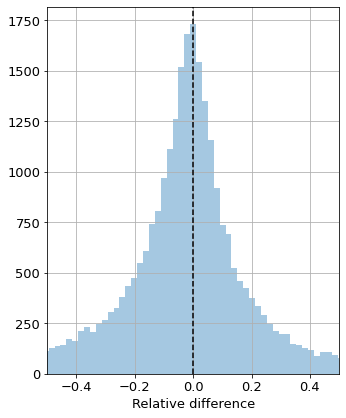

In [26]:
fig,ax= plt.subplots(figsize=(5,6))
axs = sns.distplot((dsL.zonal_velocity-dsE.mean_zonal_velocity)/ds_binned,bins=bins,kde=False)
axs.set_xlabel('Relative difference')
axs.grid();axs.axvline(0,c='k',linestyle='--')
axs.set_xlim(-0.5,0.5)
fig.tight_layout();
fig.savefig(fig_dir+'SSU_diff2.pdf',bbox_inches='tight')


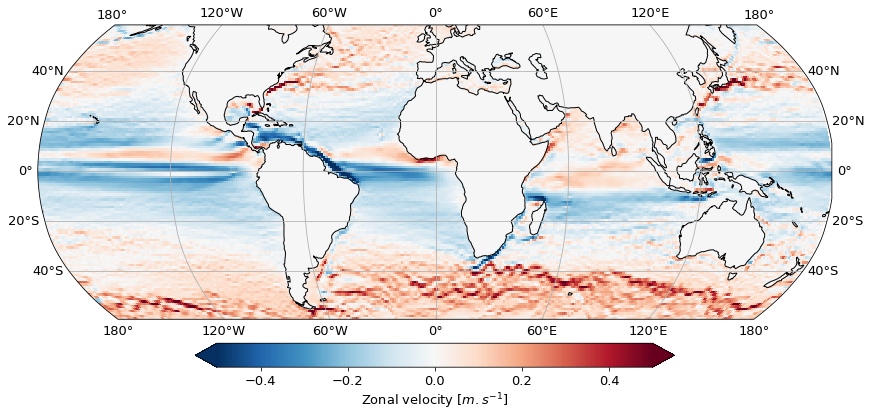

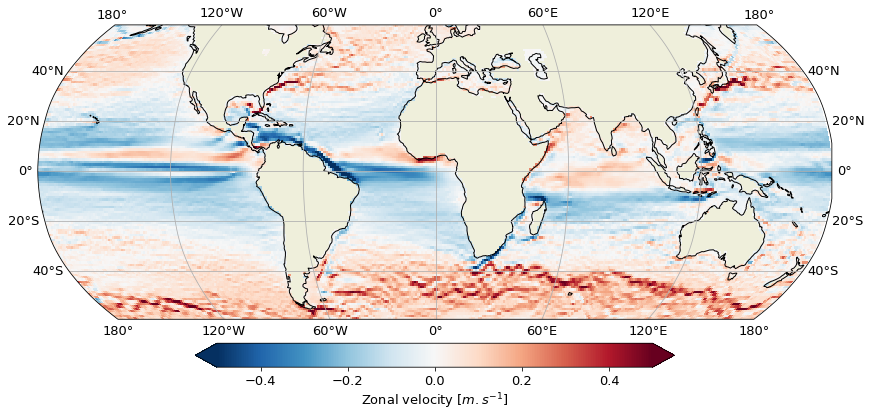

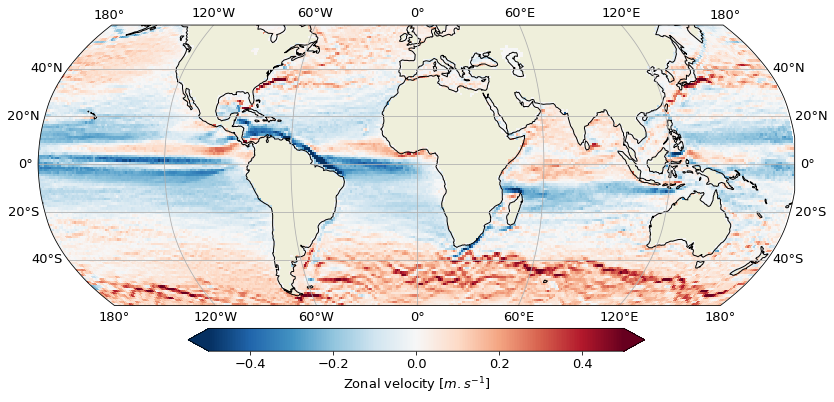

In [23]:
cmap = 'RdBu_r'
kwargs.update({'label':r'Zonal velocity [$m.s^{-1}$]'})
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps((ds_binned),colmap=cmap,vlim=(-0.5,0.5),**kwargs)
fig.tight_layout()
fig.savefig(fig_dir+'UE_mean.png')

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps((dsE.mean_zonal_velocity),colmap=cmap,vlim=(-0.5,0.5),**kwargs)
fig.tight_layout()
fig.savefig(fig_dir+'UEi_mean.png')

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps((dsL.zonal_velocity),colmap=cmap,vlim=(-0.5,0.5),**kwargs)
fig.savefig(fig_dir+'UL_mean.png')

In [28]:
dl = 1./30
lon_bins = np.arange(-180.,180., dl)
lat_bins = np.arange(-60, 60, dl)
V = 'SSU_rot'

In [29]:
N = histogram(ds_mean.lon.rename('lon'), ds_mean.lat.rename('lat'), 
              bins=[lon_bins,lat_bins], 
              dim=['i', 'j', 'face']
             ).persist()

In [30]:
cluster.close()

distributed.nanny - WARNING - Worker process still alive after 3.9999975204467777 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3.9999990463256836 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3.9999982833862306 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3.9999975204467777 seconds, killing
distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
